<h1>
    <center>
A Hands-on Introduction to Geometric Deep Learning, with Examples in PyTorch Geometric - II    
    </center>
</h1>

<h3>
    <center>
        Machine Learning and Dynamical Systems Seminar
    </center>
</h3>
<center>
    November 9, 2023
   </center>

# Node classification

In [162]:
import torch
import torch.nn.functional as F


import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv,Linear


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### dataset
[torch_geometric.datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)

In [163]:
dataset = Planetoid("DataTEST","Cora")

In [164]:
dataset = Planetoid("DataTEST","Cora")
data = dataset[0].to(device)

In [165]:
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/home/antonio/anaconda3/envs/france/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Lets investigate the "Data" object

![alt text](images/img1.png "Title")

### in depth

![alt text](images/img2.png "Title")


In [184]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [185]:
data.val_mask

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

### our first model


![alt text](images/img3.png "Title")


In [186]:
hidden_channels = 20 

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = self.conv2(x, edge_index, edge_weight)
        return x
    
model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    out_channels=dataset.num_classes,
).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model

GCN(
  (conv1): GCNConv(1433, 20)
  (conv2): GCNConv(20, 7)
)

In [187]:

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_attr)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_attr).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


In [188]:
epochs = 50

test_acc = 0
times = []
for epoch in range(0, epochs + 1):
    loss = train()
    train_acc, test_acc = test()    
    if epoch % 10 == 0:
        print(epoch,train_acc,test_acc)

0 0.18571428571428572 0.161
10 0.7428571428571429 0.538
20 0.9357142857142857 0.698
30 0.9714285714285714 0.732
40 0.9785714285714285 0.757
50 0.9785714285714285 0.77


## lets change the model

![alt text](images/img4.png "Title")

In [189]:
from torch_geometric.nn import Linear

hidden_channels = 300
hidden_channels2 = 50 

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, hidden_channels2, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels2)
        self.lin = Linear(hidden_channels2, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight).relu()
        x = self.lin(x)       
        
        return x
    
model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    hidden_channels2=hidden_channels2,
    out_channels=dataset.num_classes,
).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model

GCN(
  (conv1): GCNConv(1433, 300)
  (conv2): GCNConv(300, 50)
  (lin): Linear(50, 7, bias=True)
)

In [161]:
epochs = 50

test_acc = 0
times = []
for epoch in range(0, epochs + 1):
    loss = train()
    train_acc, test_acc = test()    
    if epoch % 10 == 0:
        print(epoch,train_acc,test_acc)

0 0.15 0.155
10 0.8785714285714286 0.671
20 0.9357142857142857 0.737
30 0.9857142857142858 0.784
40 0.9928571428571429 0.808
50 1.0 0.803


# Graph Classification

In [221]:
import torch
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [222]:

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [237]:
dataset = TUDataset("DataTEST", name="MUTAG").shuffle()
dataset

MUTAG(188)

In [227]:
dataset.data

/home/antonio/anaconda3/envs/france/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])

In [238]:
dataset.data.x

/home/antonio/anaconda3/envs/france/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

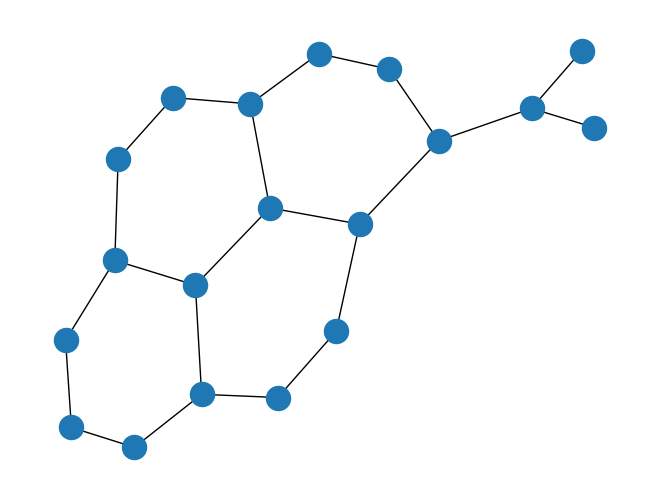

In [235]:
from torch_geometric.utils import to_networkx

g=to_networkx(dataset[0])
nx.draw(nx.Graph(g))

In [253]:
train_loader = DataLoader(dataset[:int(len(dataset)*0.9)], batch_size=3)
test_loader = DataLoader(dataset[int(len(dataset)*0.9):], batch_size=3)

### Batch training

![alt text](images/miniBatch.png "Title")

/tmp/ipykernel_14883/135093295.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(g).A


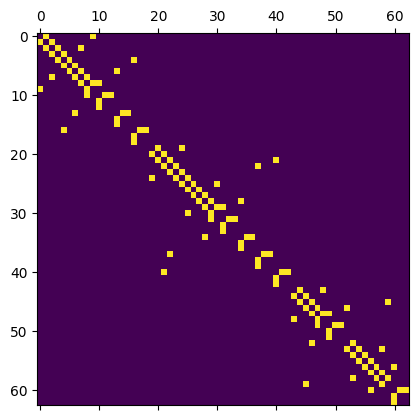

In [254]:
for d in train_loader:
    break
    
g=to_networkx(d)
A = nx.adjacency_matrix(g).A

plt.matshow(A)

In [255]:
#nx.draw(nx.Graph(g))

# The model

![alt text](images/img5.png "Title")

from torch_geometric.nn import global_add_pool

In [256]:
from torch_geometric.nn import global_add_pool

hidden_channels = 300
hidden_channels2 = 50 

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, hidden_channels2, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels2)
        self.lin = Linear(hidden_channels2, out_channels)

    def forward(self, x, edge_index,batch):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index).relu()
        
        x = global_add_pool(x, batch)  ####### the only change
        x = self.lin(x)  
        return x
    
model = GCN(
    in_channels=dataset.num_features,
    hidden_channels=hidden_channels,
    hidden_channels2=hidden_channels2,
    out_channels=dataset.num_classes,
).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model

GCN(
  (conv1): GCNConv(7, 300)
  (conv2): GCNConv(300, 50)
  (lin): Linear(50, 2, bias=True)
)

In [212]:

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

In [219]:

epochs = 50
times = []
for epoch in range(0, epochs):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 10 == 0:
        print(epoch,train_acc,test_acc)

0 0.6745562130177515 0.5789473684210527
10 0.6863905325443787 0.5789473684210527
20 0.7100591715976331 0.631578947368421
30 0.727810650887574 0.631578947368421
40 0.7337278106508875 0.631578947368421


# Let's move to a real world example

# input dataset

In [257]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


#%%
# We load graphs where the node feature x is defined by
# x = [position_x, position_y, parameter_1, ..., parameter_4, diameter]
# while y is the node target value.

#%% Loading path
path = './data/thermal_block/'

#%% Number of diameters and paramters
n_diam = 10
n_param = 5


#%% Load the graphs
G = {}

for idx_diam in range(n_diam):
    for idx_param in range(n_param):
        # Read the data
        edge_list = pd.read_csv(path + f'edge_list_diameter_{idx_diam}_param_{idx_param}.csv')        
        x = pd.read_csv(path + f'x_diameter_{idx_diam}_param_{idx_param}.csv')        
        y = pd.read_csv(path + f'y_diameter_{idx_diam}_param_{idx_param}.csv')        

        # Define the graph and assign the attributes
        G_tmp = nx.from_edgelist(edge_list.values)    
        nx.set_node_attributes(G_tmp, {idx: x.iloc[idx].values for idx in range(len(x))}, 'x')
        nx.set_node_attributes(G_tmp, {idx: y.iloc[idx].values for idx in range(len(y))}, 'y')
        
        G[(idx_diam, idx_param)] = G_tmp 

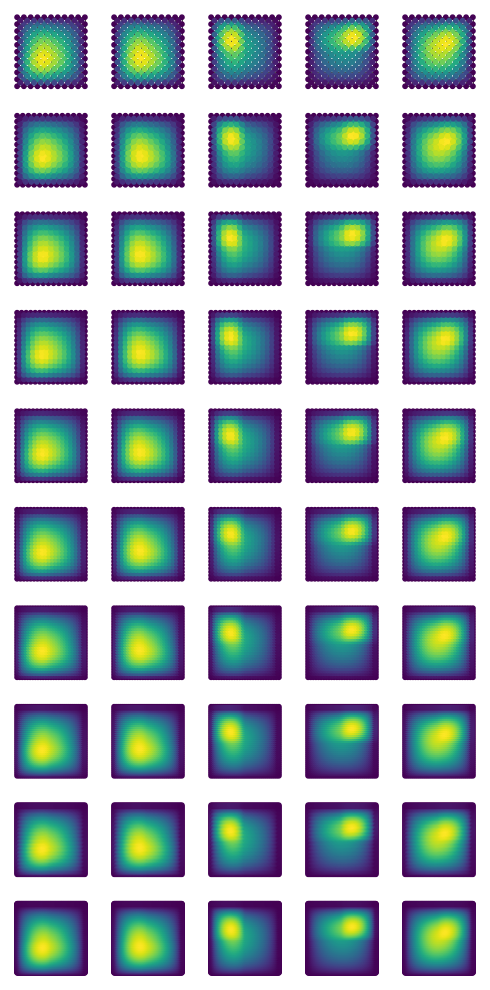

In [258]:
#%% Plot the graphs with node coloring corresponding to y
fig = plt.figure(0, figsize=(n_param, n_diam))
fig.clf()

N = n_param * n_diam

for idx_diam in range(n_diam):
    for idx_param in range(n_param):
        graph = G[(idx_diam, idx_param)]
        x = nx.get_node_attributes(graph, 'x')
        y = nx.get_node_attributes(graph, 'y')
        pos = {idx: x[idx][:2] for idx in x}
        y = np.array([y[idx] for idx in y])
        
        ax = fig.add_subplot(n_diam, n_param, 1 + idx_param + idx_diam * n_param)
        nx.draw(graph, pos=pos, 
                node_size=10, 
                width=0.5,
                node_color=y,
                ax=ax)
    
fig.tight_layout()

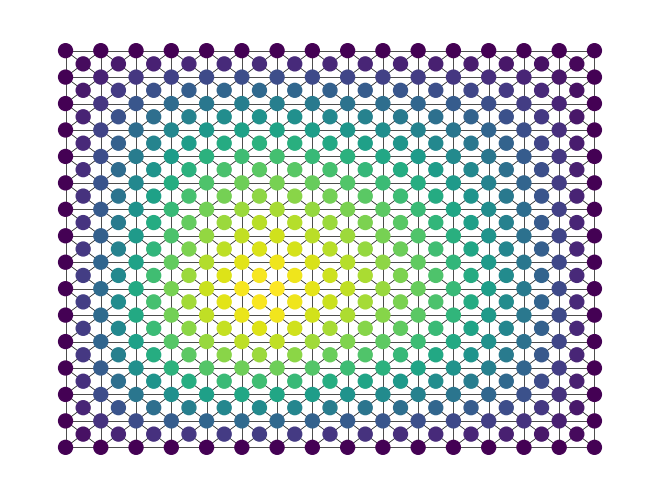

In [3]:
g = G[(3,0)]
x = nx.get_node_attributes(g, 'x')
y = nx.get_node_attributes(g, 'y')
pos = {idx: x[idx][:2] for idx in x}
y = [y[idx] for idx in y]

nx.draw(g, pos=pos, 
        node_size=100, 
        width=0.5,
        node_color=y)

# Load the graph


In [4]:
import torch
from typing import Optional, Callable
from torch_geometric.data import InMemoryDataset,Data
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import to_undirected

import pandas as pd
import networkx as nx
import numpy as np

In [5]:
class GraphReading(InMemoryDataset):  
    def __init__(self,
                 transform: Optional[Callable] = None,
                 pre_transform: Optional[Callable] = None,
                 pre_filter: Optional[Callable] = None,):
        
        super().__init__('.', transform, pre_transform, pre_filter)
        

        
        path = './data/thermal_block/'
        #%% Number of diameters and paramters
        n_diam = 10
        n_param = 1 # 5
        
        data_list = []
        
        #%% Load the graphs
        for idx_diam in range(n_diam):
            for idx_param in range(n_param):
                # Read the data
                edge_list = pd.read_csv(path + f'edge_list_diameter_{idx_diam}_param_{idx_param}.csv')        
                x = pd.read_csv(path + f'x_diameter_{idx_diam}_param_{idx_param}.csv')        
                y = pd.read_csv(path + f'y_diameter_{idx_diam}_param_{idx_param}.csv')        

                y = (y)/(y.max())
                # Define the graph and assign the attributes
                G_tmp = nx.from_edgelist(edge_list.values)    

                nx.set_node_attributes(G_tmp, {idx: x.iloc[idx].values for idx in range(len(x))}, 'x')
                nx.set_node_attributes(G_tmp, {idx: y.iloc[idx].values for idx in range(len(y))}, 'y')


                # Build the data object
                edge_index = torch.tensor([[i,j] for i,j in (G_tmp.edges())]).T
                edge_index = to_undirected(edge_index)
                x = torch.tensor(np.array(list(nx.get_node_attributes(G_tmp,"x").values())))
                y = torch.tensor(np.array(list(nx.get_node_attributes(G_tmp,"y").values())))

                data = Data(x=x, edge_index=edge_index, y=y)
                data_list.append(data)


        self.data, self.slices = self.collate(data_list)

In [259]:
dataset = GraphReading(transform=NormalizeFeatures())
dataset


GraphReading(10)

In [260]:
dataset[0].edge_index

tensor([[  0,   0,   0,  ..., 220, 220, 220],
        [  1,  11, 121,  ..., 109, 119, 120]])

In [261]:
dataset[0].x[10]

tensor([0.1803, 0.0000, 0.1037, 0.1924, 0.1726, 0.3149, 0.0361],
       dtype=torch.float64)

In [262]:
dataset[0].x.numpy()

array([[0.        , 0.04214296, 0.12120926, ..., 0.20164743, 0.36801923,
        0.04214296],
       [0.        , 0.        , 0.12654212, ..., 0.21051933, 0.38421102,
        0.04399713],
       [0.04214296, 0.        , 0.12120926, ..., 0.20164743, 0.36801923,
        0.04214296],
       ...,
       [0.18878014, 0.23912151, 0.07239454, ..., 0.12043776, 0.21980649,
        0.02517069],
       [0.20869776, 0.23325044, 0.07061706, ..., 0.11748069, 0.21440965,
        0.02455268],
       [0.22766076, 0.22766076, 0.06892477, ..., 0.11466535, 0.20927147,
        0.02396429]])

# test train split

In [68]:
from sklearn.model_selection import train_test_split

idx_train,idx_test = train_test_split(range(len(dataset)),test_size=0.1,random_state=10)

train_dataset = dataset[idx_train]
test_dataset = dataset[idx_test]

print("Train set length: \t",len(train_dataset))
print("Test set length: \t",len(test_dataset))

Train set length: 	 9
Test set length: 	 1


In [265]:
train_dataset = dataset[:9]
test_dataset = dataset[9:]

In [266]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset,batch_size=1)
test_loader = DataLoader(test_dataset,batch_size=1)

In [267]:
for data in train_loader:
    print(data)

DataBatch(x=[221, 7], edge_index=[2, 1240], y=[221, 1], batch=[221], ptr=[2])
DataBatch(x=[313, 7], edge_index=[2, 1776], y=[313, 1], batch=[313], ptr=[2])
DataBatch(x=[365, 7], edge_index=[2, 2080], y=[365, 1], batch=[365], ptr=[2])
DataBatch(x=[481, 7], edge_index=[2, 2760], y=[481, 1], batch=[481], ptr=[2])
DataBatch(x=[613, 7], edge_index=[2, 3536], y=[613, 1], batch=[613], ptr=[2])
DataBatch(x=[841, 7], edge_index=[2, 4880], y=[841, 1], batch=[841], ptr=[2])
DataBatch(x=[1405, 7], edge_index=[2, 8216], y=[1405, 1], batch=[1405], ptr=[2])
DataBatch(x=[2381, 7], edge_index=[2, 14008], y=[2381, 1], batch=[2381], ptr=[2])
DataBatch(x=[5305, 7], edge_index=[2, 31416], y=[5305, 1], batch=[5305], ptr=[2])


In [268]:
for data in test_loader:
    print(data)

DataBatch(x=[20201, 7], edge_index=[2, 120400], y=[20201, 1], batch=[20201], ptr=[2])


### Batch training
![alt text](images/miniBatch.png "Title")

In [269]:
train_loader = DataLoader(train_dataset,batch_size=1)
test_loader = DataLoader(test_dataset,batch_size=1)

In [270]:
# define the model 
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.conv1 = GCNConv(in_channels, hidden_channels)              # 7 -> 20
        self.conv2 = GCNConv(hidden_channels, int((hidden_channels)/5)) # 20 -> 4
        self.conv3 = GCNConv(int((hidden_channels)/5), out_channels)    # 4 -> 1

    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu() # relu activation function
        x = self.conv2(x, edge_index).relu() # relu activation function
        x = self.conv3(x, edge_index)
        
        return x

In [271]:
# do we have cuda?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instanziate the model
model = GCN(dataset.num_features, 20, 1).double().to(device)
# instanziate the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GCN(
  (conv1): GCNConv(7, 20)
  (conv2): GCNConv(20, 4)
  (conv3): GCNConv(4, 1)
)

In [272]:
model.conv1

GCNConv(7, 20)

In [273]:
model.conv1.lin.weight

Parameter containing:
tensor([[-0.4272,  0.1114, -0.2070,  0.2378,  0.2443,  0.1752,  0.1242],
        [ 0.0583, -0.0656, -0.0040,  0.3731,  0.3400, -0.4394, -0.2334],
        [ 0.1852, -0.1294,  0.3682,  0.3827,  0.1942, -0.3371,  0.1378],
        [-0.0095,  0.1415, -0.3100, -0.2843, -0.4324,  0.4574,  0.1822],
        [-0.4303,  0.2975,  0.2075,  0.1715, -0.3979,  0.0056, -0.3862],
        [-0.0953,  0.2843,  0.1963,  0.3960,  0.1294, -0.1331, -0.4283],
        [ 0.1974,  0.3479, -0.0659, -0.3638, -0.2556,  0.3947, -0.3885],
        [ 0.1681,  0.0508,  0.4322, -0.1735, -0.4656,  0.0479, -0.3304],
        [-0.1959, -0.4071,  0.3882, -0.3949, -0.2188, -0.2370,  0.1435],
        [-0.4527,  0.0503,  0.1395,  0.3655, -0.2857, -0.0030,  0.3124],
        [-0.0076, -0.0938, -0.4417, -0.0873,  0.3365, -0.2285, -0.1475],
        [-0.0549, -0.3539,  0.3005, -0.1299, -0.0973,  0.2393, -0.0210],
        [-0.4213,  0.2091, -0.2502, -0.2913,  0.0412, -0.1028,  0.4358],
        [ 0.1460, -0.3859,  0

In [274]:
import torch.nn.functional as F
def train(train_loader):
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x.double(), data.edge_index)
        loss = F.mse_loss(out,data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
    return total_loss/ len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    tot_loss = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x.double(), data.edge_index)
        loss = F.mse_loss(pred,data.y)
        tot_loss += float(loss)

    return tot_loss/ len(loader.dataset)
    

In [275]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0866 	Test loss: 0.0807
Epoch: 20 	Train loss: 0.0840 	Test loss: 0.0778
Epoch: 30 	Train loss: 0.0812 	Test loss: 0.0746
Epoch: 40 	Train loss: 0.0775 	Test loss: 0.0705
Epoch: 50 	Train loss: 0.0724 	Test loss: 0.0648
Epoch: 60 	Train loss: 0.0654 	Test loss: 0.0571
Epoch: 70 	Train loss: 0.0563 	Test loss: 0.0472
Epoch: 80 	Train loss: 0.0439 	Test loss: 0.0345
Epoch: 90 	Train loss: 0.0305 	Test loss: 0.0219
Epoch: 100 	Train loss: 0.0213 	Test loss: 0.0142


In [276]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def my_plot(train_loader,test_loader,device):
    
    pred_train, pred_test = [], []
    y_train, y_test = [], []
    
    for data in train_loader:
        data = data.to(device)
        pred_train.extend(model(data.x,data.edge_index).detach().cpu().numpy().reshape(-1))
        y_train.extend(data.y.detach().cpu().numpy().reshape(-1))
        
    for data in test_loader:
        data = data.to(device)
        pred_test.extend(model(data.x,data.edge_index).detach().cpu().numpy().reshape(-1))
        y_test.extend(data.y.detach().cpu().numpy().reshape(-1))  
        
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(8,4))
    ax1.set_title("Train\n r2 score: %.3f " % r2_score(pred_train,y_train))
    ax1.set_xlabel("Prediction")
    ax1.set_ylabel("Real")
    ax1.scatter(pred_train,y_train,alpha=0.002,color="blue")
    ax1.plot([0,1],"-.",color="red")

    ax2.set_title("Test\n r2 score: %.3f " % r2_score(pred_test,y_test))
    ax2.set_xlabel("Prediction")
    ax2.set_ylabel("Real")
    ax2.scatter(pred_test,y_test,alpha=0.002,color="blue")
    ax2.plot([0,1],"-.",color="red",)
    plt.show()
                   

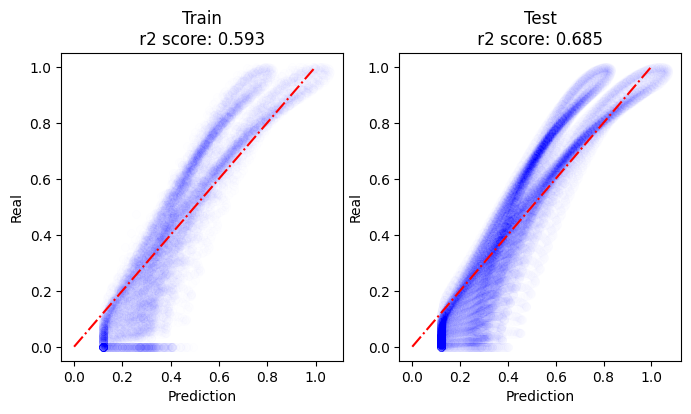

In [277]:
my_plot(train_loader,test_loader,device)

# SAGE

In [160]:
from torch_geometric.nn import SAGEConv
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        

        self.conv1 = SAGEConv(in_channels,hidden_channels)
        self.conv2 = SAGEConv(hidden_channels,hidden_channels)
        self.conv3 = SAGEConv(hidden_channels,out_channels)
        


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GIN(
  (conv1): SAGEConv(7, 10, aggr=mean)
  (conv2): SAGEConv(10, 10, aggr=mean)
  (conv3): SAGEConv(10, 1, aggr=mean)
)

In [162]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0870 	Test loss: 0.0810
Epoch: 20 	Train loss: 0.0836 	Test loss: 0.0770
Epoch: 30 	Train loss: 0.0780 	Test loss: 0.0712
Epoch: 40 	Train loss: 0.0726 	Test loss: 0.0658
Epoch: 50 	Train loss: 0.0675 	Test loss: 0.0607
Epoch: 60 	Train loss: 0.0622 	Test loss: 0.0555
Epoch: 70 	Train loss: 0.0568 	Test loss: 0.0502
Epoch: 80 	Train loss: 0.0510 	Test loss: 0.0443
Epoch: 90 	Train loss: 0.0424 	Test loss: 0.0350
Epoch: 100 	Train loss: 0.0273 	Test loss: 0.0200


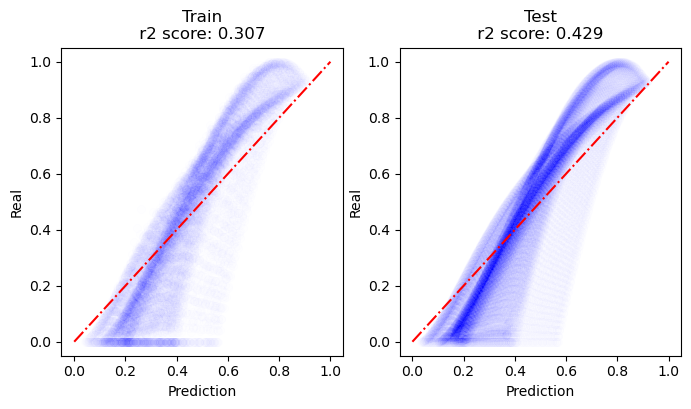

In [163]:
my_plot(train_loader,test_loader,device)

# GAT

In [164]:
from torch_geometric.nn import GATConv

class GAT_model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.conv1 = GATConv(in_channels,hidden_channels,heads=2)
        self.conv2 = GATConv(hidden_channels*2,hidden_channels,heads=2)
        self.conv3 = GATConv(hidden_channels*2,out_channels,heads=1)


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT_model(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GAT_model(
  (conv1): GATConv(7, 10, heads=2)
  (conv2): GATConv(20, 10, heads=2)
  (conv3): GATConv(20, 1, heads=1)
)

In [165]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0998 	Test loss: 0.0937
Epoch: 20 	Train loss: 0.0795 	Test loss: 0.0729
Epoch: 30 	Train loss: 0.0699 	Test loss: 0.0623
Epoch: 40 	Train loss: 0.0560 	Test loss: 0.0473
Epoch: 50 	Train loss: 0.0401 	Test loss: 0.0307
Epoch: 60 	Train loss: 0.0248 	Test loss: 0.0163
Epoch: 70 	Train loss: 0.0144 	Test loss: 0.0079
Epoch: 80 	Train loss: 0.0097 	Test loss: 0.0050
Epoch: 90 	Train loss: 0.0081 	Test loss: 0.0042
Epoch: 100 	Train loss: 0.0073 	Test loss: 0.0038


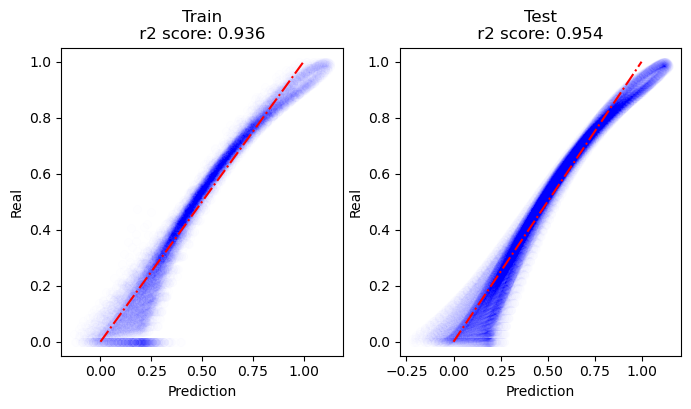

In [166]:
my_plot(train_loader,test_loader,device)

# Cheb

In [104]:
from torch_geometric.nn import ChebConv

class Cheb(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.conv1 = ChebConv(in_channels,hidden_channels,K=3)
        self.conv2 = ChebConv(hidden_channels,hidden_channels,K=3)
        self.conv3 = ChebConv(hidden_channels,out_channels,K=3)


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Cheb(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

Cheb(
  (conv1): ChebConv(7, 10, K=3, normalization=sym)
  (conv2): ChebConv(10, 10, K=3, normalization=sym)
  (conv3): ChebConv(10, 1, K=3, normalization=sym)
)

In [105]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0971 	Test loss: 0.0950
Epoch: 20 	Train loss: 0.0821 	Test loss: 0.0788
Epoch: 30 	Train loss: 0.0735 	Test loss: 0.0692
Epoch: 40 	Train loss: 0.0651 	Test loss: 0.0598
Epoch: 50 	Train loss: 0.0571 	Test loss: 0.0508
Epoch: 60 	Train loss: 0.0492 	Test loss: 0.0422
Epoch: 70 	Train loss: 0.0405 	Test loss: 0.0330
Epoch: 80 	Train loss: 0.0305 	Test loss: 0.0229
Epoch: 90 	Train loss: 0.0210 	Test loss: 0.0141
Epoch: 100 	Train loss: 0.0159 	Test loss: 0.0105


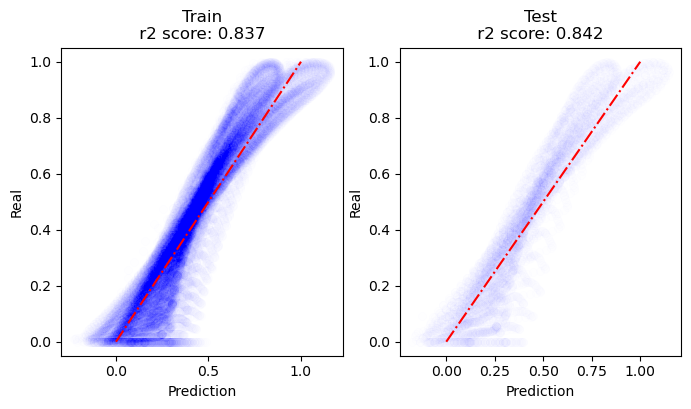

In [106]:
my_plot(train_loader,test_loader,device)

# GIN

In [107]:
from torch_geometric.nn import MLP,GINConv
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        mlp = MLP([in_channels, 20, 20])
        self.conv1 = GINConv(nn=mlp, train_eps=False)
        
        self.bn1 = torch.nn.BatchNorm1d(20)

        mlp = MLP([20, 30, 10])
        self.conv2 = GINConv(nn=mlp)
        self.bn2 = torch.nn.BatchNorm1d(10)

        mlp = MLP([10, 5, out_channels])
        self.conv3 = GINConv(nn=mlp)
        


    def forward(self, x, edge_index):
        
        x = self.conv1(x, edge_index).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.conv3(x,edge_index)
        return x

    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(dataset.num_features, 10, 1).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

model

GIN(
  (conv1): GINConv(nn=MLP(7, 20, 20))
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=MLP(20, 30, 10))
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=MLP(10, 5, 1))
)

In [108]:
for epoch in range(1, 100 + 1):
    loss = train(train_loader)
    test_loss = test(test_loader)
    if epoch % 10 == 0:
        print("Epoch:",epoch,'\tTrain loss: %.4f' % loss,'\tTest loss: %.4f' % test_loss)

Epoch: 10 	Train loss: 0.0055 	Test loss: 0.0159
Epoch: 20 	Train loss: 0.0033 	Test loss: 0.0093
Epoch: 30 	Train loss: 0.0028 	Test loss: 0.0080
Epoch: 40 	Train loss: 0.0024 	Test loss: 0.0063
Epoch: 50 	Train loss: 0.0022 	Test loss: 0.0057
Epoch: 60 	Train loss: 0.0021 	Test loss: 0.0048
Epoch: 70 	Train loss: 0.0020 	Test loss: 0.0043
Epoch: 80 	Train loss: 0.0019 	Test loss: 0.0036
Epoch: 90 	Train loss: 0.0019 	Test loss: 0.0037
Epoch: 100 	Train loss: 0.0018 	Test loss: 0.0036


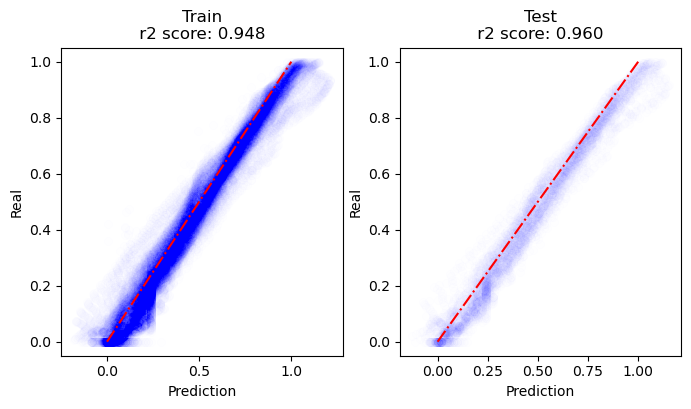

In [109]:
my_plot(train_loader,test_loader,device)